# Modelos

## Aula 29/06

### Pooled

$IDEB_{2019} = \alpha*IDEB_{2017} + \beta*IDEB_{2015} + \gamma$

### Hierarquico

regiao ~ normal(0, 10)

$IDEB_{2019} = \alpha_{regiao_n}*IDEB_{2017} + \beta_{regiao_n}*IDEB_{2015} + ... + \gamma$

### Regressão linear comum

$ideb = \alpha_{regiao_n} * tempo + \beta_{regiao_n}$

Prof disse que pode ser o modelo mais robusto. Sugestão do Fabio.

- 1 alpha e beta para cada cidade saindo de um prior comum amarrado nas hierarquias como feito acima.
- Variavel de regressão é o tempo.
- Tempo = variável categórica/numérica mesmo. Só muda a interpretação que temos com o alpha.



In [1]:
import pandas as pd
import pystan
import numpy as np
import plotly.express as px

import seaborn as sns
from matplotlib import pyplot as plt
from graphviz import Digraph

sns.set_theme()

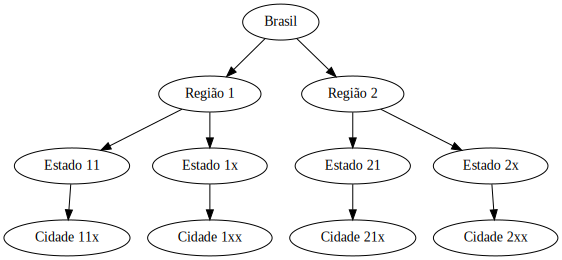

In [2]:
# TODO add no requirements
# !sudo apt install graphviz
# !pip install graphviz

g = Digraph()
g.attr(compound='true')
g.edge("Brasil", "Região 1")
g.edge("Brasil", "Região 2")
g.edge("Região 1", "Estado 11")
g.edge("Região 1", "Estado 1x")
g.edge("Região 2", "Estado 21")
g.edge("Região 2", "Estado 2x")
g.edge("Estado 11", "Cidade 11x")
g.edge("Estado 1x", "Cidade 1xx")
g.edge("Estado 21", "Cidade 21x")
g.edge("Estado 2x", "Cidade 2xx")

g

In [151]:
df_raw = pd.read_csv("../outputs/ideb_merged_middle.csv", index_col=0)

df = df_raw.dropna()

df = df.query("Rede == 'Pública'")

df_train = df.query("Ano != 2019")
df_test = df.query("Ano == 2019")

In [152]:
main_col = "Sigla da UF"
group_cols = ["Sigla da UF", "Regiões", "Ano"]
grouped_data = pd.pivot_table(df_train, index=group_cols, values=["IDEB"]).reset_index()
grouped_brasil = pd.pivot_table(df_train, index="Ano", values="IDEB").reset_index()
grouped_brasil["Sigla da UF"] = "Brasil"
grouped_brasil["Regiões"] = "Brasil"

grouped = pd.concat([grouped_data, grouped_brasil])

In [153]:
px.line(grouped, x="Ano", y="IDEB", color="Regiões")

In [154]:
px.histogram(df_train, x="IDEB", color="Regiões", 
             facet_row="Ano", marginal='histogram', 
             histnorm=None, opacity=0.5)

In [155]:
px.histogram(df_train, x="IDEB", color="Regiões", 
             facet_row="Ano", marginal='histogram', 
             histnorm='probability', opacity=0.5)

In [262]:
def balanced_sample(df, regions, years, cities_by_region=10, hierarchy_col="Regiões"):
    cities = [df[df[hierarchy_col] == r]
                .sample(cities_by_region)["Código do Município"]
                .values 
              for r in regions]
    
    cities_flat = [c for cs in cities for c in cs]
    
    balanced_df = df[df["Código do Município"].isin(cities_flat)].sort_values(by=["Código do Município", "Ano"])
    
    num_cities = balanced_df["Código do Município"].unique().shape[0]
    
    if num_cities != cities_by_region * len(regions):
        raise ValueError(f"Incorrect number of cities: {num_cities}.")
        
    return balanced_df
    

def categorize(df):
    categories = ["Sigla da UF", "Regiões", "Nome do Município", "Rede", "Código do Município"]
    df[categories] = df[categories].astype('category')

    df["UF"] = df["Sigla da UF"].cat.codes + 1
    df["Região"] = df["Regiões"].cat.codes + 1
    df["Município"] = df["Código do Município"].cat.codes + 1
    df["Rede_cat"] = df["Rede"].cat.codes + 1
    
    return df

In [301]:
regions = df_train["Regiões"].unique()
years = df_train["Ano"].unique()

sample = categorize(balanced_sample(df, regions, years, cities_by_region=10))

sample_train = sample.query("Ano not in (2017, 2019)")
sample_test = sample.query("Ano == 2017")

if (sample_train["Código do Município"].unique().shape[0] != 
    sample_test["Código do Município"].unique().shape[0]):
    raise ValueError("Incorrect number of cities on train and test.")

In [302]:
sample_train

,Código do Município,Sigla da UF,Regiões,Nome do Município,Rede,Ano,IDEB,UF,Região,Município,Rede_cat
25,1100379,RO,Norte,Alto Alegre dos Parecis,Pública,2005,3.5,16,3,1,1
5593,1100379,RO,Norte,Alto Alegre dos Parecis,Pública,2007,2.6,16,3,1,1
11161,1100379,RO,Norte,Alto Alegre dos Parecis,Pública,2009,3.5,16,3,1,1
16729,1100379,RO,Norte,Alto Alegre dos Parecis,Pública,2011,3.6,16,3,1,1
22297,1100379,RO,Norte,Alto Alegre dos Parecis,Pública,2013,4.1,16,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...
11067,5216403,GO,Centro-Oeste,Paraúna,Pública,2007,3.2,4,1,50,1
16635,5216403,GO,Centro-Oeste,Paraúna,Pública,2009,3.4,4,1,50,1
22203,5216403,GO,Centro-Oeste,Paraúna,Pública,2011,4.4,4,1,50,1
27771,5216403,GO,Centro-Oeste,Paraúna,Pública,2013,4.6,4,1,50,1


In [303]:
sample_test.tail(3)

,Código do Município,Sigla da UF,Regiões,Nome do Município,Rede,Ano,IDEB,UF,Região,Município,Rede_cat
38808,5207253,GO,Centro-Oeste,Doverlândia,Pública,2017,5.6,4,1,48,1
38899,5215504,GO,Centro-Oeste,Ouvidor,Pública,2017,5.3,4,1,49,1
38907,5216403,GO,Centro-Oeste,Paraúna,Pública,2017,4.9,4,1,50,1


In [304]:
# Algumas cidades não tem todos os valores do IDEB preenchidos
sample.groupby("Código do Município")["IDEB"].count().value_counts()

8    45
7     5
Name: IDEB, dtype: int64

# Regressão Linear Hierárquica

https://www.tqmp.org/RegularArticles/vol10-1/p013/p013.pdf

https://discourse.mc-stan.org/t/centered-vs-noncentered/1502/2

https://mc-stan.org/users/documentation/case-studies/divergences_and_bias.html

https://discourse.mc-stan.org/t/hierarchical-ar-k-models/781

## Regressão Linear Usual

$ideb = \alpha_{regiao_n} * tempo + \beta_{regiao_n}$

In [340]:
model = """
data {
  // Train data

  int<lower=0> N;            // number of samples
  int<lower=0> R;            // number of regions
  int<lower=0> C;            // number of cities
  
  int<lower=0> num_years[C]; // number of years by city

  real y[N];                 // estimated IDEB score for that sample
  
  real year[N];              // sample year of the IDEB score
  int<lower=1, upper=R> region[N]; // sample region
  int<lower=1, upper=C> city[N];   // sample city
  
  
  // Prediction data
  
  int<lower=0> N_pred;            // number of samples
  int<lower=0> R_pred;            // number of regions
  int<lower=0> C_pred;            // number of cities
  
  int<lower=0> num_years_pred[C_pred]; // number of years by city

  real y_pred[N_pred];                 // estimated IDEB score for that sample
  
  real year_pred[N_pred];              // sample year of the IDEB score
  int<lower=1, upper=R> region_pred[N_pred]; // sample region
  int<lower=1, upper=C> city_pred[N_pred];   // sample city
  
}
parameters {
  vector[R] alpha;
  vector[R] beta;
  real<lower=0> sigma;
}
model {
  int n;

  // parameters for each region
  for (r in 1:R) {
      beta[r] ~ normal(0, 10);
      alpha[r] ~ normal(0, 10);
  }
      
  // current sample
  n = 1;
  
  // loop over cities
  for (c in 1:C){
      int available_years;
      
      // get the number of data points for that city
      available_years = num_years[c];
  
      // loop over time
      for (i in 1:available_years)
          y[n] ~ normal(alpha[region[n]] * year[n] + beta[region[n]], sigma);
          
          // add sample
          n = n + 1;
  }
}
generated quantities {
  real y_rep[N];
  real y_pred_tilde[N_pred];
  int n;
  int n_pred;
  
  // // Replication loop
  
  n = 1;
  
  // loop over cities
  for (c in 1:C){
      int available_years;
      
      // get the number of data points for that city
      available_years = num_years[c];
  
      // loop over time
      for (i in 1:available_years)
          y_rep[n] = normal_rng(alpha[region[n]] * year[n] + beta[region[n]], sigma);
          n = n + 1;
  }
  
  // // Prediction loop
  
  n_pred = 1;
  
  for (c in 1:C_pred) {
      int available_years;
      available_years = num_years_pred[c];
      
      for (i in 1:available_years) {
          y_pred_tilde[n_pred] = normal_rng(alpha[region[n_pred]] * year[n_pred] + beta[region[n_pred]], sigma);
          n_pred = n_pred + 1;
      }
  }
  
}
"""

In [341]:
def generate_data(sample, suffix=''):
    data = {
        f"N{suffix}": sample.shape[0],
        f"R{suffix}": sample["Região"].unique().shape[0],
        f"C{suffix}": sample["Município"].unique().shape[0],
        f"num_years{suffix}": sample.groupby("Município")["Ano"].count().values,
        f"y{suffix}": sample["IDEB"].values,
        f"year{suffix}": sample["Ano"].values - 2004,
        f"region{suffix}": sample["Região"].values,
        f"city{suffix}": sample["Município"].values
    }
    return data

In [342]:
data = generate_data(sample_train)
data_test = generate_data(sample_test, suffix="_pred")

data.update(data_test)

In [343]:
data["y"]

array([3.5, 2.6, 3.5, 3.6, 4.1, 3.9, 3.1, 3.4, 4.2, 3.7, 4.2, 4. , 3. ,
       3.3, 3.7, 3.5, 3.9, 3.4, 2.8, 3.2, 3.2, 3.6, 3.7, 4.4, 2.5, 3. ,
       3.7, 3.8, 4.6, 4.3, 2.6, 3.6, 2.8, 3.6, 2.9, 3.4, 3. , 2.6, 2.8,
       2.9, 2.8, 3.2, 3.5, 3.8, 3.8, 3.9, 4. , 3.1, 3.2, 3.9, 3.8, 3.8,
       4.2, 3.3, 3.3, 3.3, 3.6, 3.4, 3.5, 2.8, 2.7, 3.5, 3.2, 3.7, 3.7,
       2.5, 2.8, 2.8, 3.1, 3.5, 3.8, 2.5, 2.5, 2.7, 2.8, 3.1, 3.1, 2.4,
       3.9, 3.6, 3.7, 5.6, 4.7, 2.5, 2.9, 3.1, 2.9, 3. , 3.5, 2.1, 2.3,
       2.3, 2.8, 2.8, 3.3, 2.2, 2.1, 2.6, 3. , 2.5, 2.4, 2.5, 2.8, 3.3,
       2.2, 2.7, 3.2, 2.6, 3.5, 3.5, 3.3, 3.1, 3.5, 2.5, 4.1, 3.6, 3.8,
       3.9, 3.5, 3.8, 3.7, 3.6, 4.7, 5.2, 4.8, 2.1, 3.6, 4.1, 4.4, 4.4,
       4.5, 4. , 3.7, 4.4, 5.2, 5.1, 4.4, 3.3, 4. , 4. , 3.5, 4.4, 4.1,
       4.8, 3.6, 4.9, 4.3, 4.3, 4.7, 4. , 4.5, 4.8, 4.9, 4.8, 5. , 3.7,
       3.5, 3.8, 3.7, 4.6, 4.7, 5.3, 4.1, 4.5, 4.3, 3.7, 4.8, 4.2, 4.8,
       4.9, 5.4, 5.2, 3.5, 3.9, 4.4, 3.9, 4.2, 4.3, 3.5, 3.3, 3.

In [344]:
data["city"]

array([ 1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,
        3,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,
        9,  9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12,
       12, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 15, 15,
       15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 18,
       18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20,
       21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23,
       23, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26,
       26, 26, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 29, 29, 29,
       29, 29, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 32, 32, 32,
       32, 32, 32, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 35, 35,
       35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 38,
       38, 38, 38, 38, 38

In [345]:
data['year']

array([ 1,  3,  5,  7,  9, 11,  1,  3,  5,  7,  9, 11,  1,  3,  5,  7,  9,
       11,  1,  3,  5,  7,  9, 11,  1,  3,  5,  7,  9, 11,  1,  3,  5,  7,
        9, 11,  1,  3,  5,  9, 11,  1,  3,  5,  7,  9, 11,  1,  3,  5,  7,
        9, 11,  1,  3,  5,  7,  9, 11,  1,  3,  5,  7,  9, 11,  1,  3,  5,
        7,  9, 11,  1,  3,  5,  7,  9, 11,  1,  3,  5,  7,  9, 11,  1,  3,
        5,  7,  9, 11,  1,  3,  5,  7,  9, 11,  1,  3,  5,  7,  9, 11,  1,
        3,  5,  7,  9, 11,  1,  3,  5,  7,  9, 11,  1,  3,  5,  7,  9, 11,
        1,  3,  5,  7,  9, 11,  1,  3,  5,  7,  9, 11,  1,  3,  5,  7,  9,
       11,  1,  3,  5,  7,  9, 11,  1,  3,  5,  7,  9, 11,  1,  3,  5,  7,
        9, 11,  1,  3,  5,  7,  9, 11,  1,  3,  5,  7,  9, 11,  1,  3,  5,
        7,  9,  1,  3,  5,  7,  9, 11,  1,  3,  5,  7,  9, 11,  1,  3,  5,
        7,  9, 11,  1,  3,  5,  7,  9, 11,  1,  3,  5,  7,  9, 11,  1,  3,
        5,  7,  9, 11,  1,  3,  5,  7,  9, 11,  1,  3,  5,  7,  9, 11,  1,
        3,  5,  7,  9, 11

In [346]:
fit = pystan.stan(model_code=model, 
                  data=data, 
                  control={"adapt_delta": 0.9},
                  chains=4, 
                  iter=1000, 
                  seed=42)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_70cf5423a7837af8c6de06583955c6e4 NOW.


In [347]:
print(fit)

Inference for Stan model: anon_model_70cf5423a7837af8c6de06583955c6e4.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]           0.03    0.16    9.7 -18.87  -6.49   0.03   6.51  18.65   3772    1.0
alpha[2]          -0.17    0.18  10.52 -20.87  -7.05   -0.2   6.75   20.8   3418    1.0
alpha[3]           0.09  1.4e-4 7.0e-3   0.07   0.08   0.09   0.09    0.1   2537    1.0
alpha[4]           0.21    0.17  10.01 -18.87  -6.92    0.4   6.91  19.63   3414    1.0
alpha[5]          -0.14    0.18   9.71 -19.72  -6.64  -0.01   6.54  18.54   3060    1.0
beta[1]            0.07    0.16  10.43 -19.64  -7.19   0.02   7.35  19.66   4194    1.0
beta[2]            0.35    0.16   9.75 -18.45  -6.36   0.43   6.79  19.19   3753    1.0
beta[3]            2.96  9.5e-4   0.05   2.86   2.93   2.96   2.99   3.05   2551    1.0
beta[4]            0.

ValueError: array must not contain infs or NaNs

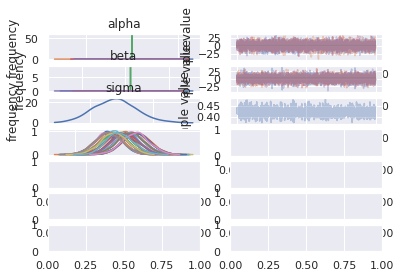

In [337]:
fit.plot()
plt.show()